In [1]:
import os
import pandas as pd

import sys; sys.path.append("..") # Adds parent directory to python modules path.
from topdown_parsers import *

import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import geopandas as gpd
from sklearn.linear_model import LinearRegression
from gerrychain import Graph, Partition
import networkx as nx
import descartes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings

warnings.filterwarnings('ignore')

In [2]:
# thresh = 1200
# n_samps = 16
dallas_pops = "TEXAS_STUB_eq_1_Dallas.dat_block_pops.csv"
dallas_shp = "DallasBlocks/dallas_county_blocks10.shp"

# df = pd.read_csv(dallas_pops)
# recons = pd.read_csv("new_dallas_reconstructions.csv")
# recons = recons[["GEOID", "TOTPOP"]]

# df = df.merge(recons, left_on="GEOID10", right_on="GEOID")
# df = df[df["TOTPOP"] < thresh]
# df = df.drop(columns=["Run_17", "Run_18", "Run_19", "Run_20", "GEOID10", "Enumdist"])
# df["GEOID"] = df["GEOID"].astype(str)
# df["State"] = df["GEOID"].apply(lambda x: x[:2])
# df["County"] = df["GEOID"].apply(lambda x: x[:5])
# df["Tract"] = df["GEOID"].apply(lambda x: x[:11])
# df["Block"] = df["GEOID"].apply(lambda x: x[:15])
# df["BlockGroup"] = df["GEOID"].apply(lambda x: x[:12])
# df.sort_values(["TOTPOP"])

In [ ]:
def convert_runs_to_delta(df, n_samps):
    for i in range(1, n_samps + 1):
        df["Run_{}".format(i)] = df["Run_{}".format(i)] - df["TOTPOP"]
        
def plot_all_runs(df, n_samps):
    fig = plt.figure()
    for i in range(1, n_samps + 1):
        plt.plot(df["TOTPOP"], df["Run_{}".format(i)], '.', color="lightcoral", rasterized=True)
    plt.axhline(0)
    
def plot_single_runs(df, run=1):
    fig = plt.figure()
    plt.plot(df["TOTPOP"], df["Run_{}".format(run)], '.', color="lightcoral", rasterized=True)
    plt.axhline(0)
    
convert_runs_to_delta(df, n_samps)
plot_all_runs(df, n_samps)

In [ ]:
plot_single_runs(df)

In [ ]:
bg = df.groupby("BlockGroup").sum()
plot_all_runs(bg, n_samps)

In [ ]:
tract = df.groupby("Tract").sum()
plot_all_runs(tract, n_samps)

In [ ]:
county = df.groupby("County").sum()
plot_all_runs(county, n_samps)

In [5]:
def morans_I(pops_fp, shp_fp, thresh, run_col, geo_col="Block", county="five"):
    """
    """
    if county == "five":
        df = process_five_counties(pops_fp, shp_fp, thresh=thresh)
    elif county == "Dallas":
        df = pd.read_csv(dallas_pops)
        recons = pd.read_csv("new_dallas_reconstructions.csv")
        recons = recons[["GEOID", "TOTPOP"]]

        df = df.merge(recons, left_on="GEOID10", right_on="GEOID")
        df = df[df["TOTPOP"] < thresh]
        df = df.drop(columns=["Run_17", "Run_18", "Run_19", "Run_20", "GEOID10", "Enumdist"])
        df["GEOID"] = df["GEOID"].astype(str)
        df["State"] = df["GEOID"].apply(lambda x: x[:2])
        df["County"] = df["GEOID"].apply(lambda x: x[:5])
        df["Tract"] = df["GEOID"].apply(lambda x: x[:11])
        df["Block"] = df["GEOID"].apply(lambda x: x[:15])
        df["BlockGroup"] = df["GEOID"].apply(lambda x: x[:12])

    shp = gpd.read_file(shp_fp)
    populated_shp = shp[shp["GEOID10"].isin(df["Block"])]
    runs_arr = ["Run_{}".format(i) for i in range(1, 17)]
    runs = df[runs_arr]
    median = runs.median(1)
    df["median"] = median
    
    g = Graph.from_geodataframe(populated_shp)
    
    geoid_idx = dict()
    idx_geoid = dict()

    for node in g.nodes:
        geoid_idx[g.nodes[node]["GEOID10"]] = node
        idx_geoid[node] = g.nodes[node]["GEOID10"]

    n = len(g.nodes)
    m = len(g.edges)
    
    populated_blocks = list(df[geo_col])

    numerator = 0
    denominator = 0

    for (i, block) in enumerate(df[geo_col]):
        x_i = df.loc[df[geo_col] == block, run_col].item()

        for neighbor in nx.neighbors(g, geoid_idx[block]):
            
            neighbor_geoid = idx_geoid[neighbor]
            if neighbor_geoid not in populated_blocks:
                continue

            x_j = df.loc[df["Block"] == neighbor_geoid, run_col].item()
            
            numerator += x_i * x_j

        denominator += x_i ** 2
        
        if i % 1000 == 0:
            print("Finished {} of {} rows.".format(i, len(df)))
    
    return (n / (2 * m)) * (numerator / denominator)

def process_five_counties(pops, shp, thresh=5000):
    """
    """
    df = pd.read_csv(pops)
    shp = gpd.read_file(shp)
    shp = shp[["geoid", "TOTPOP"]]

    shp["geoid"] = shp["geoid"].astype(str)
    df["GEOID10"] = df["GEOID10"].astype(str)
    df = df.merge(shp, left_on="GEOID10", right_on="geoid")
    df = df[df["TOTPOP"] < thresh]

    df["State"] = df["geoid"].apply(lambda x: x[:2])
    df["County"] = df["geoid"].apply(lambda x: x[:5])
    df["Tract"] = df["geoid"].apply(lambda x: x[:11])
    df["Block"] = df["geoid"].apply(lambda x: x[:15])
    df["BlockGroup"] = df["geoid"].apply(lambda x: x[:12])
    
    return df

def five_counties_plot(pops_fp, shp_fp, thresh, vmin, vmax, n_samps=16):
    df = process_five_counties(pops_fp, shp_fp, thresh=thresh)

    shp = gpd.read_file(shp_fp)
    populated_shp = shp[shp["GEOID10"].isin(df["Block"])]
    populated_g = Graph.from_geodataframe(populated_shp)
    populated_shp = populated_shp.merge(df, left_on="GEOID10", right_on="GEOID10")

    for i in range(1, n_samps + 1):
        populated_shp["Run_{}".format(i)] = populated_shp["Run_{}".format(i)] - populated_shp["TOTPOP_x"]
    
    runs_arr = ["Run_{}".format(i) for i in range(1, 17)]
    runs = populated_shp[runs_arr]
    median = runs.median(1)
    populated_shp["median"] = median

    figs, axs = plt.subplots(1, 3, figsize=(20,10))

    divider0 = make_axes_locatable(axs[0])
    cax0 = divider0.append_axes("right", size="5%", pad=0.1)
    populated_shp.plot(column="TOTPOP_x", ax=axs[0], legend=True, cmap="inferno_r", cax=cax0)
    axs[0].set_title('Total Population')

    divider1 = make_axes_locatable(axs[1])
    cax1 = divider1.append_axes("right", size="5%", pad=0.1)
    populated_shp.plot(column="Run_1", ax=axs[1], legend=True, cmap="inferno", cax=cax1, vmin=vmin, vmax=vmax)
    axs[1].set_title('Single Run')

    divider2 = make_axes_locatable(axs[2])
    cax2 = divider2.append_axes("right", size="5%", pad=0.1)
    populated_shp.plot(column="median", ax=axs[2], legend=True, cmap="inferno", cax=cax2, vmin=vmin, vmax=vmax)
    axs[2].set_title('Median of 16 runs')
    
    for i in range(3):
        axs[i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

In [ ]:
shp = gpd.read_file(dallas_shp)
populated_shp = shp[shp["GEOID10"].isin(df["Block"])]
populated_g = Graph.from_geodataframe(populated_shp)

runs_arr = ["Run_{}".format(i) for i in range(1, 17)]
runs = df[runs_arr]
median = runs.median(1)
df["median"] = median

populated_shp = shp[shp["GEOID10"].isin(df["Block"])]
populated_shp = populated_shp.merge(df, left_on="GEOID10", right_on="GEOID")
populated_shp = populated_shp.query("TOTPOP10 < {}".format(thresh))

figs, axs = plt.subplots(1, 3, figsize=(20,10))

divider0 = make_axes_locatable(axs[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.1)
populated_shp.plot(column="TOTPOP10", ax=axs[0], legend=True, cmap="inferno_r", cax=cax0)
axs[0].set_title('Total Population')

divider1 = make_axes_locatable(axs[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
populated_shp.plot(column="Run_1", ax=axs[1], legend=True, cmap="inferno", cax=cax1, vmin=-200, vmax=150)
axs[1].set_title('Single Run')

divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
populated_shp.plot(column="median", ax=axs[2], legend=True, cmap="inferno", cax=cax2, vmin=-200, vmax=150)
axs[2].set_title('Median of 16 runs')

for i in range(3):
    axs[i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

In [11]:
thresh = 5000
dallas_I = morans_I(dallas_pops, dallas_shp, thresh, "median", county="Dallas")
print(dallas_I)

Finished 0 of 25804 rows.
Finished 1000 of 25804 rows.
Finished 2000 of 25804 rows.
Finished 3000 of 25804 rows.
Finished 4000 of 25804 rows.
Finished 5000 of 25804 rows.
Finished 6000 of 25804 rows.
Finished 7000 of 25804 rows.
Finished 8000 of 25804 rows.
Finished 9000 of 25804 rows.
Finished 10000 of 25804 rows.
Finished 11000 of 25804 rows.
Finished 12000 of 25804 rows.
Finished 13000 of 25804 rows.
Finished 14000 of 25804 rows.
Finished 15000 of 25804 rows.
Finished 16000 of 25804 rows.
Finished 17000 of 25804 rows.
Finished 18000 of 25804 rows.
Finished 19000 of 25804 rows.
Finished 20000 of 25804 rows.
Finished 21000 of 25804 rows.
Finished 22000 of 25804 rows.
Finished 23000 of 25804 rows.
Finished 24000 of 25804 rows.
Finished 25000 of 25804 rows.
0.5762040571394393


Finished 0 of 5376 rows.
Finished 1000 of 5376 rows.
Finished 2000 of 5376 rows.
Finished 3000 of 5376 rows.
Finished 4000 of 5376 rows.
Finished 5000 of 5376 rows.
0.8549378066354205


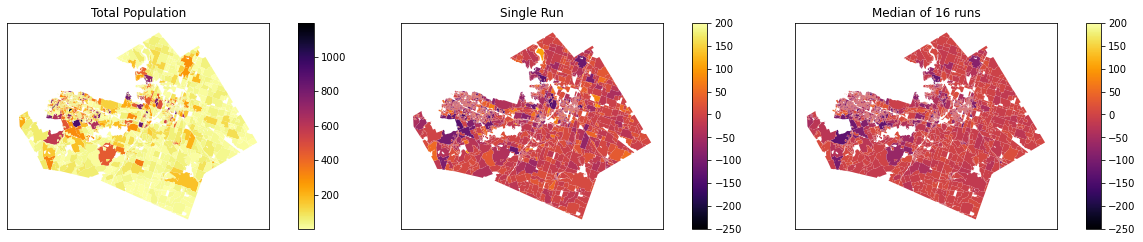

In [6]:
bell_pops = "five_county_pops/five_counties_equal_Bell.dat_block_pops.csv"
bell_shp = "Small Counties/shapes/blocks/bell_county_blocks_2010_data.shp"
thresh = 1200

five_counties_plot(bell_pops, bell_shp, thresh, -250, 200)    

bell_I = morans_I(bell_pops, bell_shp, thresh, "median")
print(bell_I)

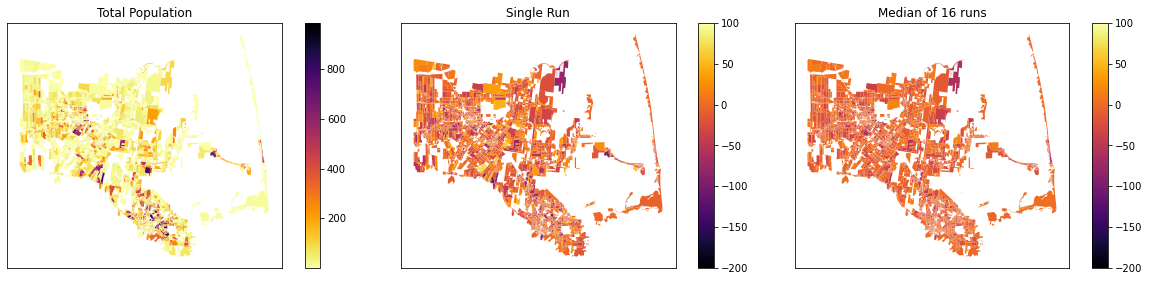

In [12]:
cameron_pops = "five_county_pops/five_counties_equal_Cameron.dat_block_pops.csv"
cameron_shp = "Small Counties/shapes/blocks/cameron_county_blocks_2010_data.shp"
thresh = 1000

five_counties_plot(cameron_pops, cameron_shp, thresh, -200, 100)    

# cameron_I = morans_I(cameron_pops, cameron_shp, thresh, "median")
# print(cameron_I)

Finished 0 of 5857 rows.
Finished 1000 of 5857 rows.
Finished 2000 of 5857 rows.
Finished 3000 of 5857 rows.
Finished 4000 of 5857 rows.
Finished 5000 of 5857 rows.
0.8850759724469477


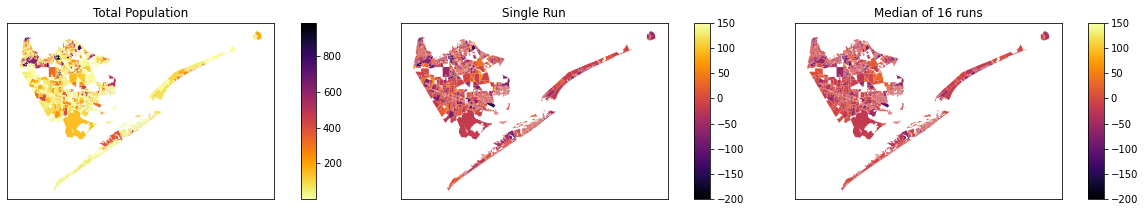

In [8]:
galveston_pops = "five_county_pops/five_counties_equal_Galveston.dat_block_pops.csv"
galveston_shp = "Small Counties/shapes/blocks/galveston_county_blocks_2010_data.shp"
thresh = 1000

five_counties_plot(galveston_pops, galveston_shp, thresh, -200, 150)    

galveston_I = morans_I(galveston_pops, galveston_shp, thresh, "median")
print(galveston_I)

Finished 0 of 4752 rows.
Finished 1000 of 4752 rows.
Finished 2000 of 4752 rows.
Finished 3000 of 4752 rows.
Finished 4000 of 4752 rows.
0.8165050930726981


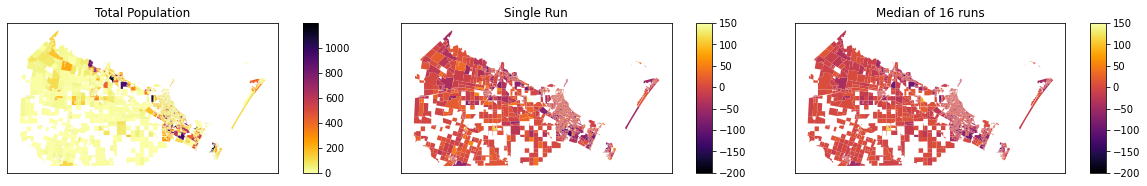

In [9]:
nueces_pops = "five_county_pops/five_counties_equal_Nueces.dat_block_pops.csv"
nueces_shp = "Small Counties/shapes/blocks/nueces_county_blocks_2010_data.shp"
thresh = 1200

five_counties_plot(nueces_pops, nueces_shp, thresh, -200, 150)    

nueces_I = morans_I(nueces_pops, nueces_shp, thresh, "median")
print(nueces_I)

Finished 0 of 4963 rows.
Finished 1000 of 4963 rows.
Finished 2000 of 4963 rows.
Finished 3000 of 4963 rows.
Finished 4000 of 4963 rows.
0.8378374807686872


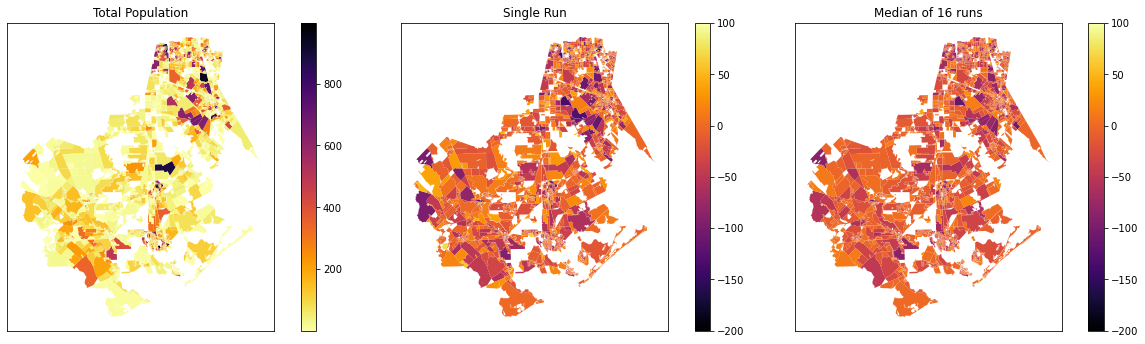

In [10]:
brazoria_pops = "five_county_pops/five_counties_equal_Brazoria.dat_block_pops.csv"
brazoria_shp = "Small Counties/shapes/blocks/brazoria_county_blocks_2010_data.shp"
thresh = 1000

five_counties_plot(brazoria_pops, brazoria_shp, thresh, -200, 100)    

brazoria_I = morans_I(brazoria_pops, brazoria_shp, thresh, "median")
print(brazoria_I)